In [26]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import json

import matplotlib.pyplot as plt

# 학습된 모델 이용하기

In [28]:
model = models.resnet101(pretrained = True)
model.eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 데이터셋 준비

In [29]:
CLASSES = json.load(open('imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]

# 이미지 불러오기

In [30]:
img = Image.open('schuna.jpg')

img_transforms = transforms.Compose([
    transforms.Resize((224, 224), Image.BICUBIC),
    transforms.ToTensor(),
])

img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)

print("Image Tensor :", img_tensor.size())

Image Tensor : torch.Size([1, 3, 224, 224])


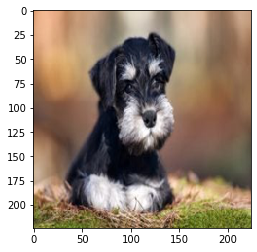

In [32]:
original_img_view = img_tensor.squeeze(0).detach()
original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy()
plt.imshow(original_img_view)

# 모델 성능체크

In [9]:
output = model(img_tensor)
prediction = output.max(1, keepdim=False)[1]

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print("Predicted No.:", prediction_idx)
print("Predicted Name :", prediction_name)

Predicted No.: 196
Predicted Name : miniature schnauzer


# FGSM 공격 함수

In [33]:
def fgsm_attack(image, epsilon, gradient):
    sign_gradient = gradient.sign()
    
    perturbed_image = image + epsilon * sign_gradient
    
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

# 적대적 공격 예제 생성

In [34]:
img_tensor.requires_grad_(True)

output = model(img_tensor)

loss = F.nll_loss(output, torch.tensor([196]))

model.zero_grad()
loss.backward()

gradient = img_tensor.grad.data

epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)

output = model(perturbed_data)

# 적대적 예제로 생성된 이미지로 모델 성능 확인

In [23]:
perturbed_prediction = output.max(1, keepdim=True)[1]

perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]

print("Predicted No :", perturbed_prediction_idx)
print("Predicted Name :", perturbed_prediction_name)

Predicted No : 196
Predicted Name : miniature schnauzer


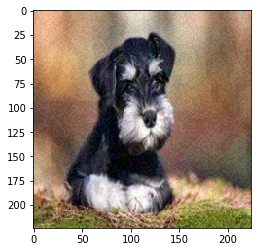

In [35]:
perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.transpose(0,2).transpose(0,1).numpy()

plt.imshow(perturbed_data_view)

# 원본과 적대적 예제 비교

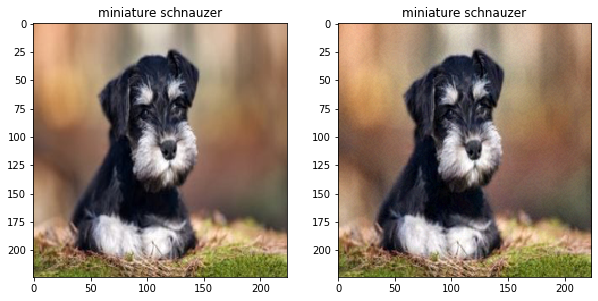

In [25]:
f, a = plt.subplots(1,2,figsize=(10,10))

a[0].set_title(prediction_name)
a[0].imshow(original_img_view)

a[1].set_title(perturbed_prediction_name)
a[1].imshow(perturbed_data_view)

plt.show()